In [190]:
from wield.control import SISO #, SISOFResponse
from wield.control.AAA import tfAAA
from wield.iirrational.v2 import data2filter

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import altair as alt
from moku.instruments import MultiInstrument, LaserLockBox, DigitalFilterBox, FrequencyResponseAnalyzer, SpectrumAnalyzer

In [191]:
MIM = MultiInstrument('192.168.50.97', force_connect=True, platform_id=4) #192.168.50.97 Moku pro 1 ---- 192.168.50.63 Moku pro 4

# Set up multinstrument mode skeleton

In [192]:
llb = MIM.set_instrument(1, LaserLockBox)
fra = MIM.set_instrument(2, FrequencyResponseAnalyzer)
dfb = MIM.set_instrument(3, DigitalFilterBox)
spa = MIM.set_instrument(4, SpectrumAnalyzer)

In [193]:
connections = [dict(source="Input1", destination="Slot1InA"), # REFL PD to demodulation in laser lock box
               dict(source="Input2", destination="Slot1InB"), # TRANS PD to monitor in laser lock box
               dict(source="Slot1OutA", destination="Slot3InA"), # PID output -control signal- to summing junction in digital filter box
               dict(source="Slot1OutA", destination="Slot4InA"), #control signal to spectrum analyzer
               dict(source="Slot1OutA", destination="Slot2InB"), #control signal to slot B of frequency response analyzer
               dict(source="Slot1OutB",destination="Output3"), # modulation signal to EOM
               dict(source="Slot2OutA", destination="Slot3InB"), #Excitation signal from frequency response analyzer to summing junction in digital filter box
               dict(source="Slot3OutA", destination="Slot2InA"), #control signal plus excitation to slot A of frequency response analyzer
               dict(source="Slot3OutA", destination="Output1"), #control signal plus excitation goes to actuator
               dict(source="Slot3OutA",destination = "Slot4InB") #control signal plus excitation to spectrum analyzer
               ]

MIM.set_connections(connections=connections)

[{'destination': 'Slot1InA', 'source': 'Input1'},
 {'destination': 'Slot1InB', 'source': 'Input2'},
 {'destination': 'Slot2InA', 'source': 'Slot3OutA'},
 {'destination': 'Slot2InB', 'source': 'Slot1OutA'},
 {'destination': 'Slot3InA', 'source': 'Slot1OutA'},
 {'destination': 'Slot3InB', 'source': 'Slot2OutA'},
 {'destination': 'Slot4InA', 'source': 'Slot1OutA'},
 {'destination': 'Slot4InB', 'source': 'Slot3OutA'},
 {'destination': 'Output1', 'source': 'Slot3OutA'},
 {'destination': 'Output3', 'source': 'Slot1OutB'}]

In [194]:
#set inputs
MIM.set_frontend(1,"50Ohm","AC","0dB")
MIM.set_frontend(2,"1MOhm","DC","0dB")

#set outputs
MIM.set_output(1, "0dB")
#MIM.set_output(2, "0dB") #to piezo
MIM.set_output(3, "14dB") #to EOM

{'output_gain': '14dB'}

# Set digital filter box to sum the excitation and control signal then apply an all-pass filter

In [195]:
dfb.set_control_matrix(1, input_gain1=1, input_gain2=1)
dfb.set_control_matrix(2, input_gain1=0, input_gain2=0)

filter_coefficients = [
    [1.0000000000, 1.0000000000, 0.0000000000, 0.0000000000, 0.0000000000, 0.0000000000],
    [1.0000000000, 1.0000000000, 0.0000000000, 0.0000000000, 0.0000000000, 0.0000000000],
    [1.0000000000, 1.0000000000, 0.0000000000, 0.0000000000, 0.0000000000, 0.0000000000],
    [1.0000000000, 1.0000000000, 0.0000000000, 0.0000000000, 0.0000000000, 0.0000000000]]

dfb.set_custom_filter(1, "39.06MHz", coefficients=filter_coefficients) 

dfb.set_input_gain(1,gain = 0)
dfb.set_output_gain(1,gain = 0)

dfb.enable_output(1,True,True)

{'output': True, 'signal': True}

# Configure the laser lock box

In [196]:
llb.set_demodulation(mode="Modulation",frequency=50.68e6,phase=112)
llb.set_aux_oscillator(enable = True,frequency=50.68e6,amplitude=2,output = "OutputB")
llb.set_output(2, signal=False, output=True)

llb.set_output_offset(1, offset=0.0)

llb.set_monitor(1, 'ErrorSignal')
llb.set_monitor(2, 'Input2')
llb.set_acquisition_mode(mode="Precision")
llb.set_trigger(type="Edge", source="Scan", level=0,edge="Rising")

{'edge': 'Rising',
 'hf_reject': False,
 'holdoff': 0.0,
 'hysteresis': 0.001,
 'level': 0.0,
 'noise_reject': False,
 'nth_event': 1}

In [197]:
def PIS_controller(prop_gain_dB,int_crossover_Hz,int_saturation_dB):
    int_crossover = int_crossover_Hz*2*np.pi #convert from hz to rad/s
    int_saturation_mag = 10**(int_saturation_dB/20)
    prop_gain_mag = 10**(prop_gain_dB/20)
    return SISO.zpk([-int_crossover],[-int_crossover*prop_gain_mag/int_saturation_mag],prop_gain_mag)

In [198]:
propGain = -15 #in dB
intSaturation = 23 #in dB
intCrossover = 400 #in Hz

K_model = PIS_controller(propGain,intCrossover,intSaturation)

llb.set_pid_by_frequency(channel=1,  int_crossover = intCrossover, int_saturation = intSaturation,prop_gain = propGain, diff_crossover = None,diff_saturation =None, double_int_crossover = None,invert=True)

{'diff_crossover': 160000.0,
 'diff_saturation': 15.0,
 'double_int_crossover': 310.0,
 'int_crossover': 400.0,
 'int_saturation': 23.0,
 'invert': True,
 'prop_gain': -15.0}

In [199]:
def aquire_lock(MokuLaserLockBox):
    scan_freq = 10
    scan_amp = 1
    MokuLaserLockBox.set_scan_oscillator(enable=True,amplitude = scan_amp, frequency = scan_freq, output ="OutputA",shape =  "Triangle")
    MokuLaserLockBox.set_output(1, signal=False, output=True)
    MokuLaserLockBox.set_timebase(0.0,1/(4*scan_freq))
    data = MokuLaserLockBox.get_data(wait_complete=True)
    t = np.array(data['time'])
    err = np.array(data['ch1'])
    trans = np.array(data['ch2'])
    med_err = np.median(err)
    t_res = t[np.argmax(trans)]
    V_res = scan_amp*t_res*4*scan_freq
    MokuLaserLockBox.set_setpoint(-med_err)
    MokuLaserLockBox.set_output_offset(1,offset=V_res)
    MokuLaserLockBox.set_scan_oscillator(enable=False,amplitude = scan_amp, frequency = scan_freq, output ="OutputA",shape =  "Triangle")
    MokuLaserLockBox.set_output(1, signal=True, output=True)


# Run cell below until lock is aquired

In [217]:
aquire_lock(llb)

In [201]:
raise ValueError('breakpoint')

ValueError: breakpoint

## When locked take transfer function

In [218]:
#configure the frequency sweep
fra.set_sweep(start_frequency=200, stop_frequency=10e6, num_points=256,
                averaging_time=1e-3, averaging_cycles=200, settling_cycles=10,
                settling_time=1e-3,dynamic_amplitude = True)
fra.measurement_mode('InIn1')
fra.set_output(1, 0.01)

delay = fra.start_sweep() 
print(delay)
data = pd.DataFrame(fra.get_data(wait_complete = True)['ch2'])

fra.stop_sweep()

{'estimated_sweep_time': 55.06270239410413}


In [219]:
fra.stop_sweep()

In [220]:
data['frequency'] = data['frequency'].apply(lambda x: x*2*np.pi) #convert Hz to rad/s
data['magnitude'] = data['magnitude'].apply(lambda x: 10**(x/20)) #convert dB to magnitude
data['complex'] = data.apply(lambda x: x.magnitude*np.exp(1.0j*x.phase*np.pi/180), axis=1)
data['label'] = 'Loop measured'

In [221]:
data.to_csv('cavity.csv', index=False)

## Take noise spectrum

In [222]:
spa.sa_measurement(channel=1,frequency1=200,frequency2=10e6,window='BlackmanHarris')
spectrum = pd.DataFrame(spa.get_data(units='Vrms',psdUnits=True,wait_complete=True))
spectrum.to_csv("spectrum.csv",index=False)

In [223]:
OpenLoopf = SISO.SISOFResponse(f = data['frequency'].apply(lambda x: x/(2*np.pi)),tf = data['complex'])
OpenLoopw = SISO.SISOFResponse(w = data['frequency'],tf = data['complex'])

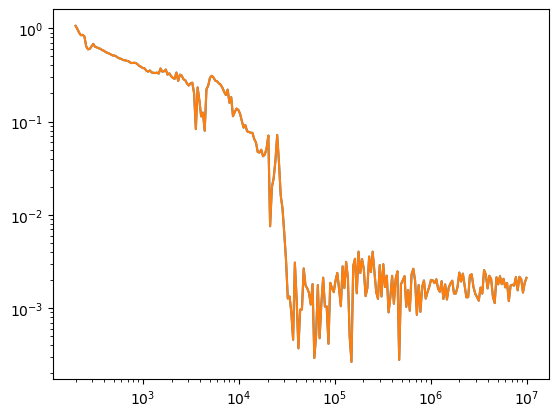

In [224]:
plt.loglog(*OpenLoopf.fplot_mag)
plt.loglog(*OpenLoopw.fplot_mag)

In [225]:
K_tf = K_model.fresponse(f=data['frequency'].apply(lambda x: x/(2*np.pi))).tf #convert rad/s to Hz
kmag = [abs(x) for x in K_tf]
kphase = [np.angle(x)*180/np.pi for x in K_tf]
Kdf = pd.DataFrame({'frequency':data['frequency'],'magnitude':kmag,'phase':kphase})
Kdf['label'] = "Controller model"
Kdf['complex'] = K_tf

In [226]:
Pdf = pd.DataFrame({'frequency':data['frequency']})
Pdf['label'] = "Plant"
Pdf['complex'] = data['complex']/Kdf['complex']
Pdf['magnitude'] = Pdf['complex'].apply(lambda x: abs(x))
Pdf['phase'] = Pdf['complex'].apply(lambda x: np.angle(x)*180/np.pi)

In [227]:
def downsample_dataframe(df, column1, column2, n_samples):
    # Calculate the step size for downsampling
    step = len(df) // n_samples
    
    # Downsample the first column by taking evenly spaced samples
    downsampled_column1 = df[column1][::step].reset_index(drop=True)
    
    # Downsample the second column by taking the average of complex numbers in each window
    downsampled_column2 = []
    for i in range(0, len(df[column2]), step):
        window = df[column2][i:i+step]
        avg_complex = np.mean(window)
        downsampled_column2.append(avg_complex)

    downsampled_column2 = pd.Series(downsampled_column2)
    
    return downsampled_column1, downsampled_column2

In [228]:
F, C = downsample_dataframe(Pdf,'frequency','complex',70)

In [229]:
downsampledf = pd.DataFrame({'frequency':F,'complex':C})
downsampledf['magnitude'] = downsampledf['complex'].apply(lambda x: abs(x))
downsampledf['phase'] = downsampledf['complex'].apply(lambda x: np.angle(x)*180/np.pi)
downsampledf['label'] = 'downsampled'

In [230]:
f = downsampledf['frequency'].apply(lambda x: x/(2*np.pi)).to_numpy() #convert rad/s to Hz
c = downsampledf['complex'].to_numpy()
barycentric = tfAAA(F_Hz=f, xfer=c)
all_z = barycentric.zeros
all_p = barycentric.poles
k = barycentric.gain
z = np.array(all_z) * (np.pi * 2) #convert Hz to rad/s
p = np.array(all_p) * (np.pi * 2) #convert Hz to rad/s
AAAfit = SISO.zpk(z,p,k)

/opt/python-dev/wield-project-lab/wield-control/src/wield/control/SISO/zpk.py:134: NumericalWarning: StateSpace is large (>50 states), using reduced response fiducial auditing heuristics. TODO to make this smarter
  warnings.warn(f"StateSpace is large (>{self.N_MAX_FID} states), using reduced response fiducial auditing heuristics. TODO to make this smarter", util.NumericalWarning)


In [231]:
AAAfit_tf = AAAfit.fresponse(f=data['frequency'].apply(lambda x: x/(2*np.pi))).tf #convert rad/s to Hz
AAAfitmag = [abs(x) for x in AAAfit_tf]
AAAfitphase = [np.angle(x)*180/np.pi for x in AAAfit_tf]
AAAfitdf = pd.DataFrame({'frequency':data['frequency'],'magnitude':AAAfitmag,'phase':AAAfitphase})
AAAfitdf['label'] = "AAA fit"
AAAfitdf['complex'] = AAAfit_tf

In [232]:
iir_results = data2filter(
    F_Hz=f,#from a few cells ago
    xfer=c,
    mode='reduce',
    zeros=tuple(z), 
    poles=tuple(p),
    gain=k,
    SNR_phase_rel=0,
    SNR=np.ones_like(f),
    relative_degree=-4,
    # resavg_RthreshOrdDn=1.01,
    baseline_only=True,
    # coding_map=fitters_ZPK.codings_s.coding_maps.RI
    # trust_SNR = True,
    )

/opt/python-dev/wield-project-lab/wield-iirrational/src/wield/iirrational/fitters_ZPK/MRF.py:1361: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = y_min / y_max


TEE_LOGFILE None


------------:Q-ranked order reduction:


3W   2.29    Fitter_checkpoint improvement succeed, None


4P   3.65    order reduced annealing


3W   3.92    Fitter_checkpoint improvement succeed, None
3W   4.19  Fitter_checkpoint improvement succeed, None


5P   4.21  zero flipping, maxzp 23, residuals=2.05e-01, 2.05e-01, reldeg=0
5P   4.29  zero flipped, maxzp 23, residuals=2.05e-01, reldeg=0
5P   4.37  zero flipped, maxzp 23, residuals=2.05e-01, reldeg=0
------------:selective order reduction:
5P   7.17    order reduced to 22, residuals=1.30e-01, reldeg=-1
5P   8.45    order reduced to 21, residuals=1.26e-01, reldeg=-1
5P   9.07    order reduced to 20, residuals=1.22e-01, reldeg=-1
2A   9.77  Baseline fit residuals: 1.22e-01, at order 20
BASELINE:  20
------------:investigations:
2I   9.77    max(z, p)       ChiSq.
                   order    avg. res.    med. res.    max. res.
             -----------  -----------  -----------  -----------
                      20      0.12224   0.00979275      1.13414


3W   9.74  Fitter_checkpoint improvement succeed, None


In [233]:
freq = data['frequency'].apply(lambda x: x/(2*np.pi))
iirdf = pd.DataFrame({'frequency':data['frequency'],'complex':iir_results.fitter.xfer_eval(freq)})
iirdf['magnitude'] = iirdf['complex'].apply(lambda x: abs(x))
iirdf['phase'] = iirdf['complex'].apply(lambda x: np.angle(x)*180/np.pi)
iirdf['label'] = 'data2filter'

In [234]:
alldata = pd.concat([data,Kdf,Pdf,downsampledf,AAAfitdf,iirdf])
alldata['frequency (Hz)'] = alldata['frequency'].apply(lambda x: x/(2*np.pi)) #convert frequencies to Hz for plotting
alldata = alldata.drop(['complex'],axis = 1)

In [235]:
magnitudechart = alt.Chart(alldata).mark_line().encode(
    x=alt.X('frequency (Hz):Q').scale(type="log"),
    y=alt.Y('magnitude:Q').scale(type="log"),
    color='label:N',
).properties(
    width=400,
    height=200
)

phasechart = alt.Chart(alldata).mark_line().encode(
    x=alt.X('frequency (Hz):Q').scale(type="log"),
    y=alt.Y('phase:Q'),
    color='label:N',
).properties(
    width=400,
    height=100
)

chart = alt.vconcat(magnitudechart,phasechart)
chart

alt.VConcatChart(...)

In [237]:
MIM.relinquish_ownership()